In [1]:
%load_ext autoreload
%autoreload 2

import torch
import matplotlib.pyplot as plt

/home/flo/anaconda3/envs/bdl2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


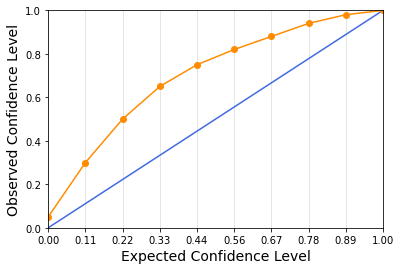

In [2]:
from training.regresssion import plot_calibration

class FakeResults:
    pass
results = FakeResults()
results.quantile_ps = torch.linspace(0, 1, 10)

# Underconfident
results.observed_cdf = torch.tensor([0.05, 0.3, 0.5, 0.65, 0.75, 0.82, 0.88, 0.94, 0.98, 1])

# Overconfident
#results.observed_cdf = torch.tensor([0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.55, 0.7, 0.9])

# Overconfident Quantile
#results.observed_cdf = torch.tensor([0.8, 0.77, 0.72, 0.65, 0.55, 0.45, 0.4, 0.35, 0.34, 0.33])

plot_calibration(None, results, plt.subplot(), include_text=False)
plt.savefig("results/figs/underconfident_regression.pdf")

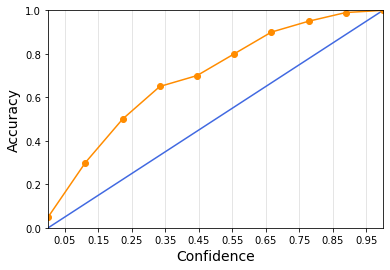

In [4]:
from training.calibration import reliability_diagram, ClassificationCalibrationResults

# Overconfident
#accuracies = torch.tensor([0, 0.05, 0.06, 0.1, 0.15, 0.25, 0.35, 0.5, 0.63, 0.9])

# Underconfident
accuracies = torch.tensor([0.05, 0.3, 0.5, 0.65, 0.7, 0.8, 0.9, 0.95, 0.99, 1])

ClassificationCalibrationResults(10, accuracies, torch.linspace(0, 1, 10)).plot_reliability(plt.subplot(), False, None, False, False, include_sizes=False)
#reliability_diagram(10, accuracies, torch.linspace(0, 1, 10), plt.subplot(), False, False, False, False, False)
plt.savefig("results/figs/underconfident_classification.pdf")

In [105]:
from training.spline import interpolate
from experiments.toy_regression import gap_datasets, NOISE, plot_grid
from scipy.interpolate import CubicSpline
from training.regresssion import normalize, denormalize

device = torch.device("cpu")

dataset, dataloader, testset = gap_datasets(device)

def create_splines(outside_std, gap_std):
    def spline_infer(x, samples):
        x = denormalize(x, dataset.x_mean, dataset.x_std)

        t = torch.cat((torch.linspace(0, 0.13, 10), torch.linspace(0.4, 0.55, 10)))
        output = []
        for _ in range(samples):
            xs = torch.cat((t, torch.tensor([-0.4, 0.9, 0.23])))
            left_y = torch.normal(torch.tensor(-1.0), torch.tensor(outside_std))
            right_y = torch.normal(torch.tensor(1.0), torch.tensor(outside_std))
            gap_y = torch.normal(torch.tensor(0.6), torch.tensor(gap_std))
            ys = torch.cat((dataset.eval(t, torch.tensor(0)), torch.tensor([left_y, right_y, gap_y])))
            xs, sort_indices = torch.sort(xs)
            ys = ys[sort_indices]
            spline = CubicSpline(xs, ys, bc_type="natural")
            output.append(torch.from_numpy(spline(x)))

        output = torch.stack(output)
        output = normalize(output, dataset.y_mean, dataset.y_std)
        return torch.stack((output, NOISE.expand(output.shape) / dataset.y_std), dim=-1)

    return spline_infer
    
#dataset.plot_predictions(-0.3, 0.8, create_splines(0.5, 0.2), 100, plt.subplot(), plot_ground_truth=True, alpha=0.3)
#plt.scatter([-0.4, 0.9, 0.23], [-1.0, 1.0, 0.6])

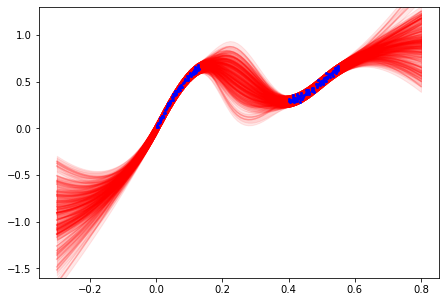

In [117]:
dataset.plot_predictions(-0.3, 0.8, create_splines(0.5, 0.15), 50, plt.subplot(), plot_ground_truth=False, alpha=0.3)
plt.ylim(-1.6, 1.3)
plt.tight_layout(pad=0)
plt.savefig("results/figs/good_epistemic.pdf")

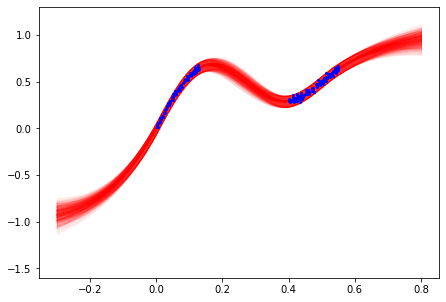

In [115]:
dataset.plot_predictions(-0.3, 0.8, create_splines(0.1, 0.03), 50, plt.subplot(), plot_ground_truth=False, alpha=0.1)
plt.ylim(-1.6, 1.3)
plt.tight_layout(pad=0)
plt.savefig("results/figs/narrow_epistemic.pdf")

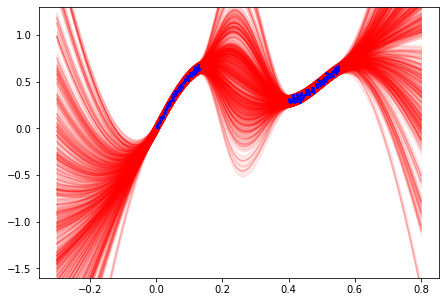

In [116]:
dataset.plot_predictions(-0.3, 0.8, create_splines(2.0, 0.4), 100, plt.subplot(), plot_ground_truth=False, alpha=0.3)
plt.ylim(-1.6, 1.3)
plt.tight_layout(pad=0)
plt.savefig("results/figs/wide_epistemic.pdf")

In [6]:
import os
from experiments.uci.results import UCIResults

all_results = {}

os.chdir("c:/Uni/Bachelor/results/UCI_GAP/results")
for method in os.listdir("."):
    if not os.path.isdir(method):
        continue
    print(method)
    os.chdir(method)
    
    for dataset in os.listdir("."):
        if not os.path.isdir(dataset):
            continue
        name = dataset.split('__')[1][1:]
        if name not in all_results:
            all_results[name] = {}
        print(f"  {name}")

        results = []
        for file in os.listdir(dataset + "/log"):
            if not file.endswith(".pyc"):
                continue
            results.append(UCIResults.load(dataset + "/log/" + file))
        all_results[name][method] = results
    os.chdir("..")

Ensemble-5
  concrete
  energy
  housing
  power
  wine
  yacht
LRVI-10
  concrete
  energy
  housing
  power
  wine
  yacht
LRVI-2
  concrete
  energy
  housing
  power
  wine
  yacht
LRVI-5
  concrete
  energy
  housing
  power
  wine
  yacht
MAP
  concrete
  energy
  housing
  power
  wine
  yacht
MCDropout
  concrete
  energy
  housing
  power
  wine
  yacht
MFVI
  concrete
  energy
  housing
  power
  wine
  yacht
Multi-MFVI-5
  concrete
  energy
  housing
  power
  wine
  yacht
MultiMCDropout
  concrete
  energy
  housing
  power
  wine
  yacht
MultiSWAG
  concrete
  energy
  housing
  power
  wine
  yacht
SGLD
  concrete
  energy
  housing
  power
  wine
  yacht
slurmlog
SWAG
  concrete
  energy
  housing
  power
  wine
  yacht


In [7]:
import numpy as np

def print_method(method, method_results):
    times = []
    lml = []
    mean_mse = []
    mse_of_means = []
    qce = []
    for rep in method_results:
        times.append(rep.time)
        lml.append(rep.results.average_lml)
        mean_mse.append(rep.results.mean_mse)
        mse_of_means.append(rep.results.mse_of_means)
        qce.append(rep.results.qce)
    times = torch.tensor(times)
    lml = torch.tensor(lml)
    mean_mse = torch.tensor(mean_mse)
    mse_of_means = torch.tensor(mse_of_means)
    qce = torch.tensor(qce)

    print((f"            & {method}"
        f" & ${lml.mean():.2f} \\pm {lml.std() / np.sqrt(len(lml)):.2f}$"
        #f" & ${mean_mse.mean():.2f} \\pm {mean_mse.std() / np.sqrt(len(mean_mse)):.2f}$"
        f" & ${mse_of_means.mean():.2f} \\pm {mse_of_means.std() / np.sqrt(len(mse_of_means)):.2f}$"
        f" & ${qce.mean():.2f} \\pm {qce.std() / np.sqrt(len(qce)):.2f}$"
        #f" & ${times.mean():.2f} \\pm {times.std() / np.sqrt(len(times)):.2f}$"
        " \\\\"
    ))

def print_dataset(dataset, dataset_results):
    print("        \\midrule")
    print("        \\multirow{" + str(len(dataset_results)) + "}{*}{" + dataset + "}")
    print_method("MAP", dataset_results["MAP"])
    print_method("Ensemble-5", dataset_results["Ensemble-5"])
    print_method("MCD", dataset_results["MCDropout"])
    print_method("MultiMCD-5", dataset_results["MultiMCDropout"])
    print_method("SWAG", dataset_results["SWAG"])
    print_method("MultiSWAG-5", dataset_results["MultiSWAG"])
    print_method("MFVI", dataset_results["MFVI"])
    print_method("MultiMFVI-5", dataset_results["Multi-MFVI-5"])
    print_method("LRVI-2", dataset_results["LRVI-2"])
    print_method("LRVI-5", dataset_results["LRVI-5"])
    print_method("LRVI-10", dataset_results["LRVI-10"])
    print_method("SLGD", dataset_results["SGLD"])

print_dataset("Housing", all_results["housing"])
print_dataset("Concrete", all_results["concrete"])
print_dataset("Energy", all_results["energy"])
print_dataset("Wine", all_results["wine"])
print_dataset("Yacht", all_results["yacht"])
print_dataset("Power", all_results["power"])

        \midrule
        \multirow{12}{*}{Housing}
            & MAP & $-4.23 \pm 0.09$ & $14.69 \pm 0.47$ & $0.17 \pm 0.00$ \\
            & Ensemble-5 & $-3.83 \pm 0.06$ & $12.85 \pm 0.35$ & $0.12 \pm 0.00$ \\
            & MCD & $-2.98 \pm 0.03$ & $12.73 \pm 0.34$ & $0.09 \pm 0.00$ \\
            & MultiMCD-5 & $-2.94 \pm 0.03$ & $12.36 \pm 0.35$ & $0.07 \pm 0.00$ \\
            & SWAG & $-2.93 \pm 0.03$ & $12.96 \pm 0.35$ & $0.09 \pm 0.00$ \\
            & MultiSWAG-5 & $-2.91 \pm 0.02$ & $12.60 \pm 0.31$ & $0.08 \pm 0.00$ \\
            & MFVI & $-2.82 \pm 0.03$ & $12.96 \pm 0.39$ & $0.05 \pm 0.00$ \\
            & MultiMFVI-5 & $-2.79 \pm 0.03$ & $12.46 \pm 0.37$ & $0.04 \pm 0.00$ \\
            & LRVI-2 & $-2.78 \pm 0.03$ & $12.71 \pm 0.40$ & $0.05 \pm 0.00$ \\
            & LRVI-5 & $-2.76 \pm 0.03$ & $13.22 \pm 0.46$ & $0.05 \pm 0.00$ \\
            & LRVI-10 & $-2.77 \pm 0.03$ & $12.70 \pm 0.50$ & $0.04 \pm 0.00$ \\
            & SLGD & $-2.72 \pm 0.01$ & $16.73 \pm 0.59$ & $

Ensemble-5
MAP
MCDropout
MultiMCDropout
MultiSWAG


/tmp/ipykernel_4418/1699504541.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


SWAG
        MAP & $0.05(\textrm{O})$ & $0.11(\textrm{O})$ & $0.19(\textrm{O})$ & $0.29(\textrm{O})$ & $0.44(\textrm{O})$ \\
        Ensemble-5 & $0.07(\textrm{U})$ & $0.09(\textrm{U})$ & $0.09(\textrm{U})$ & $0.11(\textrm{U})$ & $0.27(\textrm{O})$ \\
        MCD & $0.06(\textrm{U})$ & $0.05(\textrm{U})$ & $0.03(\textrm{U})$ & $0.06(\textrm{O})$ & $0.27(\textrm{O})$ \\
        MultiMCD-5 & $0.11(\textrm{U})$ & $0.13(\textrm{U})$ & $0.12(\textrm{U})$ & $0.10(\textrm{U})$ & $0.22(\textrm{O})$ \\
        SWAG & $0.19(\textrm{U})$ & $0.23(\textrm{U})$ & $0.22(\textrm{U})$ & $0.20(\textrm{U})$ & $0.15(\textrm{O})$ \\
        MultiSWAG-5 & $0.23(\textrm{U})$ & $0.28(\textrm{U})$ & $0.29(\textrm{U})$ & $0.27(\textrm{U})$ & $0.14(\textrm{O})$ \\


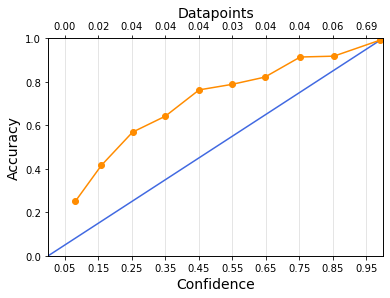

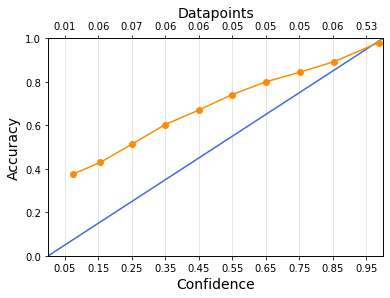

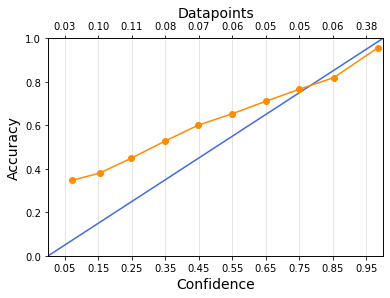

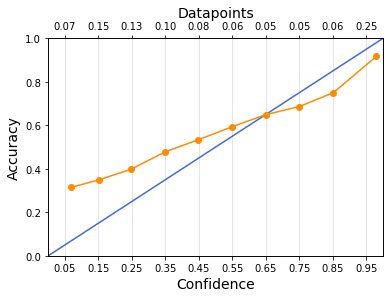

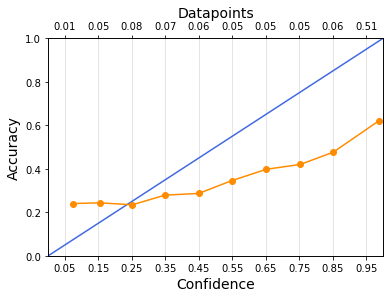

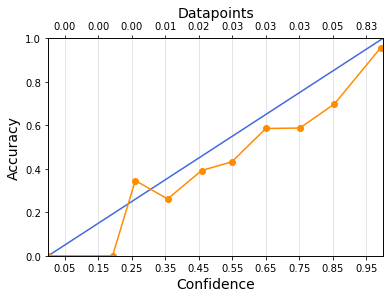

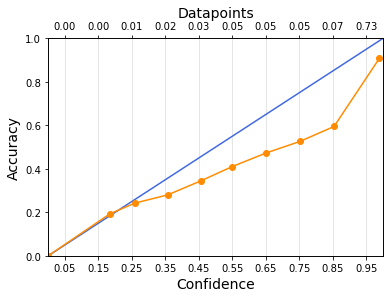

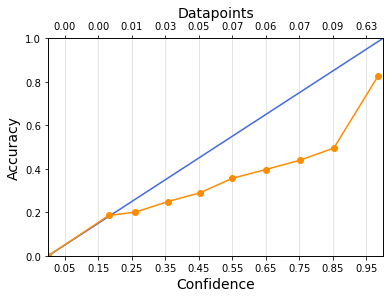

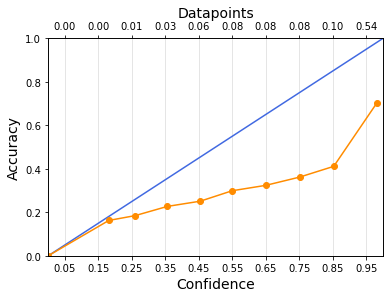

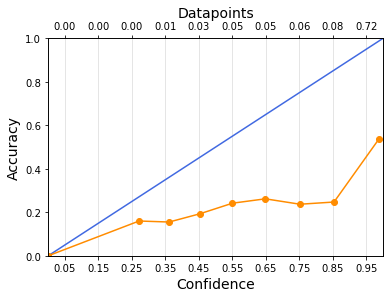

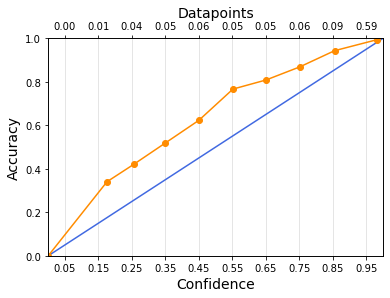

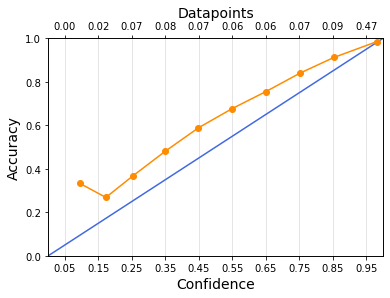

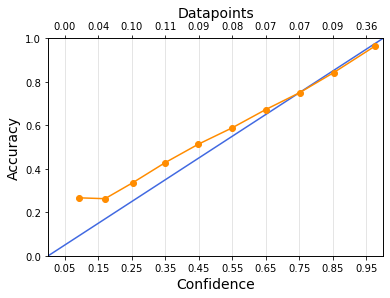

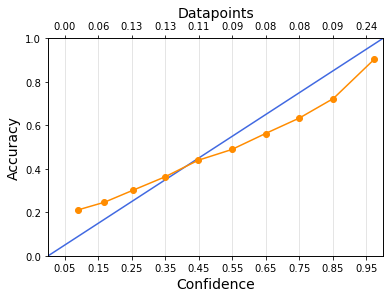

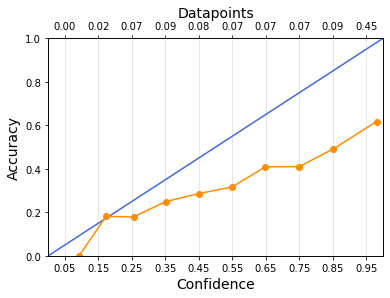

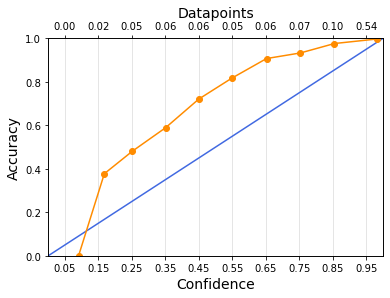

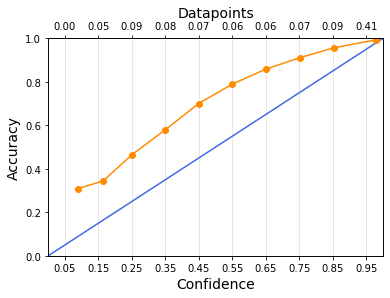

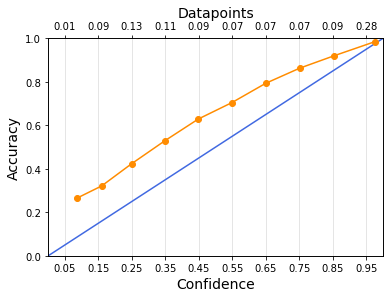

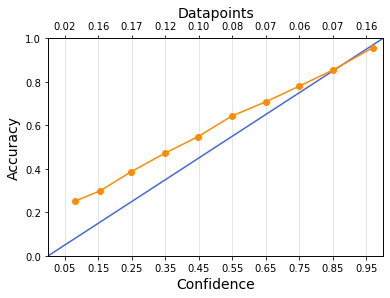

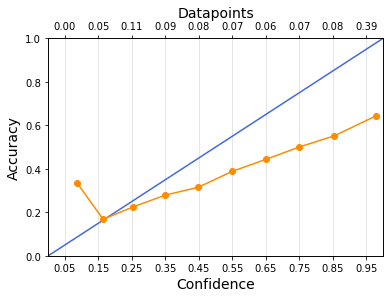

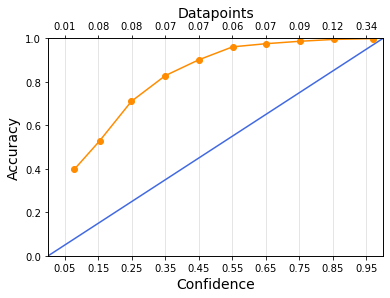

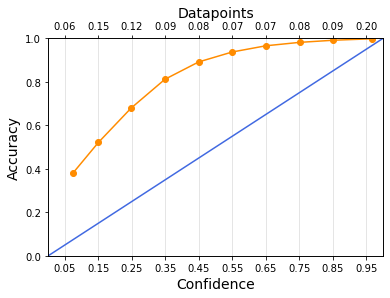

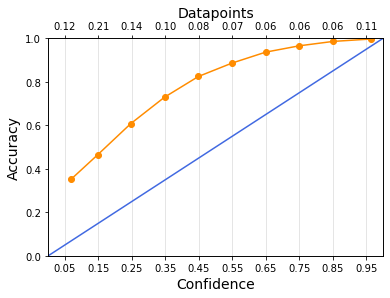

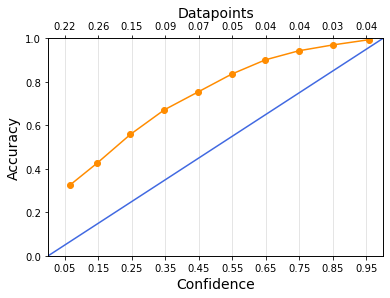

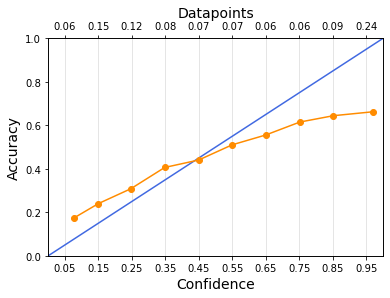

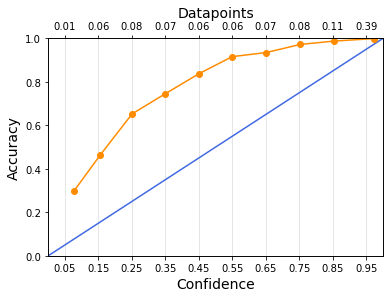

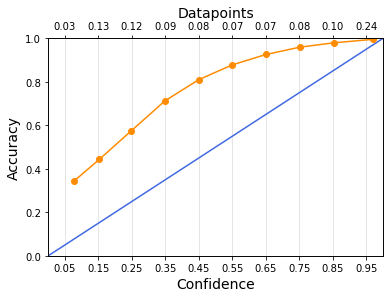

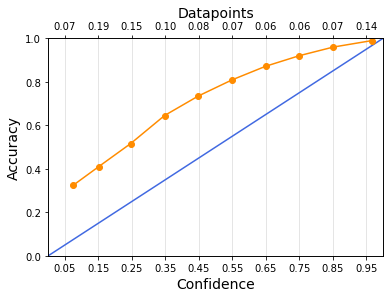

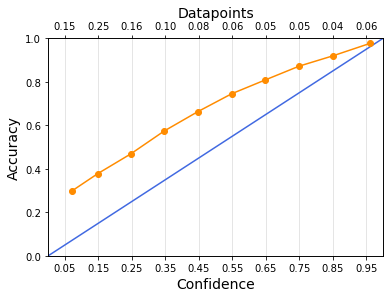

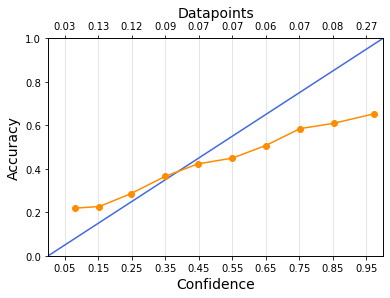

In [12]:
import os
from experiments.fmnist.results import FMNISTResults
from experiments.cifar.results import CIFARResults
import numpy as np
import torch
import matplotlib.pyplot as plt

all_results = {}

#in_path = "/mnt/d/Uni/Bachelorarbeit/results/fMNIST/results"
#out_path = "/home/flo/VariationalBayesianDL/results/fMNIST"
#variants = ["normal", "corrupted"]

in_path = "/mnt/d/Uni/Bachelorarbeit/results/CIFAR10/3/results"
out_path = "/home/flo/VariationalBayesianDL/results/CIFAR10"
variants = ["normal", "0", "2", "4", "stl10"]

os.chdir(in_path)
for method in os.listdir("."):
    if not os.path.isdir(method) or method == "slurmlog":
        continue
    print(method)
    
    variant_results = [[] for _ in variants]
    for file in os.listdir(method + "/log"):
        if not file.endswith(".pyc"):
            continue
        for i, variant in enumerate(variants):
            if file.endswith(f"_{variant}.pyc"):
                variant_results[i].append(CIFARResults.load(method + "/log/" + file))
    all_results[method] = variant_results

    for variant, name in zip(variant_results, variants):
        if len(variant) > 0:
            fig, ax = plt.subplots()
            variant[0].calibration_results.plot_reliability(ax, include_text=False)
            fig.savefig(f"{out_path}/plots/reliability/{method}_{name}.pdf")

def num(val, std=True, sign=None):
    mean = val.mean()
    marker = "" if sign is None else f"(\\textrm{{{sign}}})"
    if std:
        return f"${mean:.2f}{marker} \\pm {val.std() / np.sqrt(len(val)):.2f}$"
    else:
        return f"${val.mean():.2f}{marker}$"

def print_method(method, method_results):
    times = []

    accs = [[] for _ in variants]
    eces = [[] for _ in variants]
    seces = [[] for _ in variants]
    lmls = [[] for _ in variants]

    for i, variant in enumerate(method_results):
        for rep in variant:
            times.append(rep.time)
            accs[i].append(rep.accuracy)
            eces[i].append(rep.calibration_results.ece)
            seces[i].append(rep.calibration_results.signed_ece)
            lmls[i].append(rep.log_likelihood)

    accs = torch.tensor(accs)
    eces = torch.tensor(eces)
    seces = torch.tensor(seces)
    lmls = torch.tensor(lmls)

    times = torch.tensor(times)

    print(f"        {method}", end="")
    for acc, ece, sece, lml in zip(accs, eces, seces, lmls):
        print((f" & {num(acc, std=False)}"
        f" & {num(lml, std=False)}"
        f" & {num(ece, sign='O' if sece.mean() < 0 else 'U', std=False)}"), end="")
    print(" \\\\")

print_method("MAP", all_results["MAP"])
print_method("Ensemble-5", all_results["Ensemble-5"])
print_method("MCD", all_results["MCDropout"])
print_method("MultiMCD-5", all_results["MultiMCDropout"])
print_method("SWAG", all_results["SWAG"])
print_method("MultiSWAG-5", all_results["MultiSWAG"])
#print_method("VOGN", all_results["VOGN"])
#print_method("MultiVOGN", all_results["MultiVOGN"])
#print_method("MFVI", all_results["MFVI"])
#print_method("MultiMFVI-5", all_results["MultiMFVI-5"])

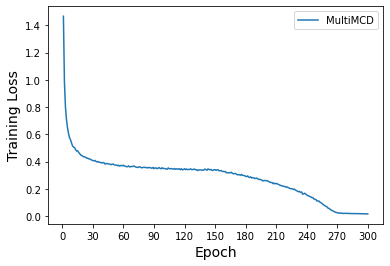

In [35]:
from training.util import plot_losses
from experiments.fmnist.results import FMNISTResults
from experiments.cifar.results import CIFARResults
from experiments.weather.results import WeatherResults
import matplotlib.pyplot as plt

plot_losses("MultiMCD", CIFARResults.load("/mnt/d/Uni/Bachelorarbeit/results/CIFAR10/3/results/MAP/log/rep_00results_0.pyc").losses, plt.subplot())

In [30]:
x = CIFARResults.load("/mnt/d/Uni/Bachelorarbeit/results/CIFAR10/3/results/MAP/log/rep_00results_4.pyc")
print(x.accuracy)
conf = 0
for c, count in zip(x.calibration_results.bin_confidences, x.calibration_results.bin_counts):
    conf += c * count
print(conf / sum(x.calibration_results.bin_counts))

tensor(0.5309)
0.824482546751907


In [9]:
import torch
from experiments.base.cifar import cifar10_testloader, cifar10_corrupted_testloader, imshow
testloader = cifar10_testloader("/mnt/d/Uni/Bachelorarbeit/linux/data/", batch_size=1, shuffle=False)

Files already downloaded and verified


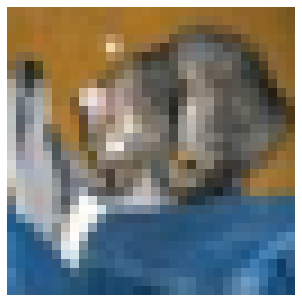

In [37]:
imshow(next(iter(testloader))[0][0])

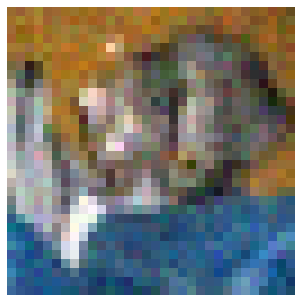

In [41]:
corr_testloader = cifar10_corrupted_testloader("/mnt/d/Uni/Bachelorarbeit/linux/data/", intensity=0, batch_size=1, shuffle=False)
imshow(next(iter(corr_testloader))[0][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


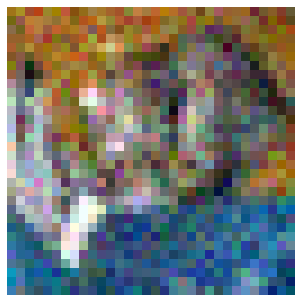

In [42]:
corr_testloader = cifar10_corrupted_testloader("/mnt/d/Uni/Bachelorarbeit/linux/data/", intensity=2, batch_size=1, shuffle=False)
imshow(next(iter(corr_testloader))[0][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


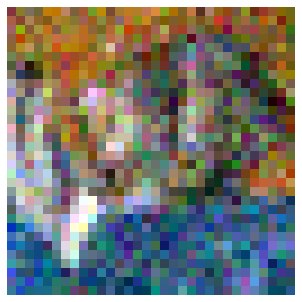

In [43]:
corr_testloader = cifar10_corrupted_testloader("/mnt/d/Uni/Bachelorarbeit/linux/data/", intensity=4, batch_size=1, shuffle=False)
imshow(next(iter(corr_testloader))[0][0])